# EMINST Dataset Classification Problem for Pytorch

### Check Module and prepare data

In [ ]:
# Check for GPU
!nvidia-smi

Wed Nov 22 13:35:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Import necessary package
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

import mlxtend
import random

from functools import wraps
import time

from tqdm.auto import tqdm

from torch.utils.data import DataLoader

In [ ]:
try:
  import torchmetrics
except:
  !pip install torchmetrics
  import torchmetrics
from torchmetrics import Accuracy

In [ ]:
# Print out version number
print(f'torch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')
print(f'matplotlib version: {matplotlib.__version__}')
print(f'numpy version: {np.__version__}')
print(f'mlxtend version: {mlxtend.__version__}')
print(f'torchmetrics version: {torchmetrics.__version__}')

torch version: 2.1.0+cu118
torchvision version: 0.16.0+cu118
matplotlib version: 3.7.1
numpy version: 1.23.5
mlxtend version: 0.22.0
torchmetrics version: 1.2.0


In [ ]:
# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Define functions to measure time
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

In [ ]:
# Setup train_data
train_data = datasets.EMNIST(root='data',
                             split='letters',
                             train=True,
                             download=True,
                             transform=ToTensor(),
                             target_transform=None)

# Setup test_data
test_data = datasets.EMNIST(root='data',
                            split='letters',
                            train=False,
                            download=True,
                            transform=ToTensor(),
                            target_transform=None)

In [ ]:
train_data, test_data

(Dataset EMNIST
     Number of datapoints: 124800
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset EMNIST
     Number of datapoints: 20800
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

### Visualise Data

In [ ]:
# See first training sample
img, label = train_data[0]
img.shape, label

(torch.Size([1, 28, 28]), 23)

In [ ]:
# Set class_names
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_to_idx, len(class_names)

({'N/A': 0,
  'a': 1,
  'b': 2,
  'c': 3,
  'd': 4,
  'e': 5,
  'f': 6,
  'g': 7,
  'h': 8,
  'i': 9,
  'j': 10,
  'k': 11,
  'l': 12,
  'm': 13,
  'n': 14,
  'o': 15,
  'p': 16,
  'q': 17,
  'r': 18,
  's': 19,
  't': 20,
  'u': 21,
  'v': 22,
  'w': 23,
  'x': 24,
  'y': 25,
  'z': 26},
 27)

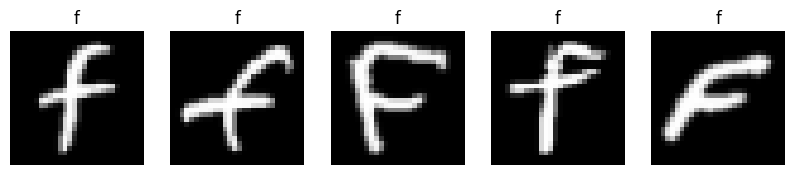

In [ ]:
# Plot random plots from 1 class using class_num
class_num = 6
index = np.random.choice(torch.nonzero(train_data.targets==class_num).squeeze().numpy(),
                            size=5,
                            replace=True)
fig = plt.figure(figsize=(10, 3))
for fig, i in enumerate(index):
  img, label = train_data[i]
  plt.subplot(1, 5, fig+1)
  plt.imshow(img.squeeze().T, cmap='gray')
  plt.title(class_names[label])
  plt.axis(False)

In [ ]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

# Print out dataloader results
print(f'Train Dataloaders: {train_dataloader}\nLength: {len(train_dataloader)}\nBatch Size: {train_dataloader.batch_size}')
print(f'Test Dataloaders: {test_dataloader}\nLength: {len(test_dataloader)}\nBatch Size: {test_dataloader.batch_size}')

Train Dataloaders: <torch.utils.data.dataloader.DataLoader object at 0x7b626466dba0>
Length: 3900
Batch Size: 32
Test Dataloaders: <torch.utils.data.dataloader.DataLoader object at 0x7b6263bdafe0>
Length: 650
Batch Size: 32


In [ ]:
# Check out train_dataloader
train_feature_batch, train_label_batch = next(iter(train_dataloader))
train_feature_batch.shape, train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

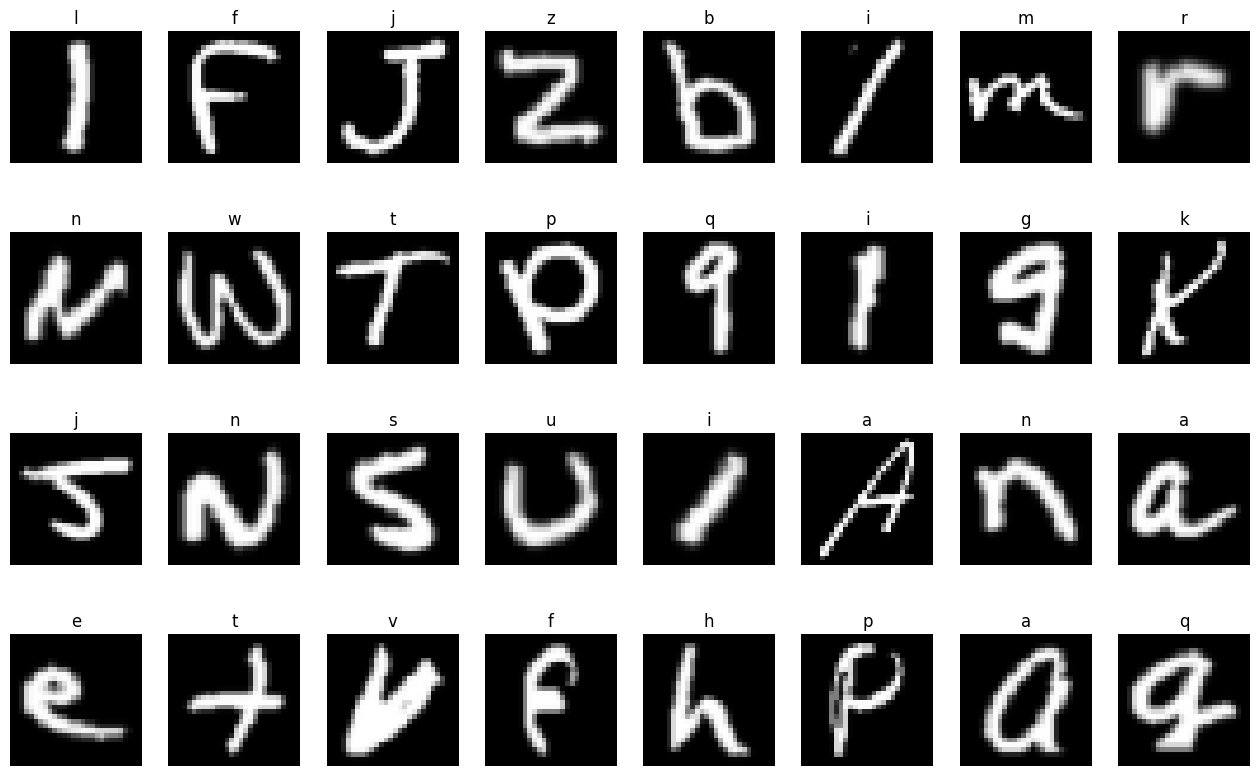

In [ ]:
# Show one batch of data
fig = plt.figure(figsize=(16, 10))
rows, columns = 4, 8
for i in range(len(train_feature_batch)):
  plt.subplot(rows, columns, i+1)
  plt.imshow(train_feature_batch[i].squeeze().T, cmap='gray')
  plt.title(class_names[train_label_batch[i]])
  plt.axis(False)

### Create model

In [ ]:
INPUT_SHAPE = 1
HIDDEN_UNITS = 20
OUTPUT_SHAPE = len(class_names)

# Recreate Sequential Layer to test
conv_block_1 = nn.Sequential(
    nn.Conv2d(in_channels=INPUT_SHAPE,
              out_channels=HIDDEN_UNITS,
              kernel_size=5,
              stride=1,
              padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=HIDDEN_UNITS,
              out_channels=HIDDEN_UNITS,
              kernel_size=5,
              stride=1,
              padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2)
)
conv_block_2 = nn.Sequential(
    nn.Conv2d(in_channels=HIDDEN_UNITS,
              out_channels=HIDDEN_UNITS,
              kernel_size=5,
              stride=1,
              padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=HIDDEN_UNITS,
              out_channels=HIDDEN_UNITS,
              kernel_size=5,
              stride=1,
              padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2)
)
flatten_layer = nn.Flatten()

print(f'Block 1\n----------')
output = conv_block_1(train_feature_batch)
print(f'Output Shape on conv_block_1: {output.shape}')
print(f'Block 2\n----------')
output = conv_block_2(output)
print(f'Output Shape on conv_block_2: {output.shape}')
print(f'\nClassifier\n--------')
output = flatten_layer(output)
print(f'Output Shape on flatten_layer: {output.shape}')
final_linear_input = len(output[0])

Block 1
----------
Output Shape on conv_block_1: torch.Size([32, 20, 12, 12])
Block 2
----------
Output Shape on conv_block_2: torch.Size([32, 20, 4, 4])

Classifier
--------
Output Shape on flatten_layer: torch.Size([32, 320])


In [ ]:
class MNISTModel(nn.Module):
  '''
  Model architecture copying TinyVGG from:
  https://poloclub.github.io/cnn-explainer/
  '''
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):

    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=5,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=5,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=5,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=5,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=320,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [ ]:
#Instantiate the model
model = MNISTModel(input_shape=INPUT_SHAPE,
                   hidden_units=HIDDEN_UNITS,
                   output_shape=OUTPUT_SHAPE)
model

MNISTModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=320, out_features=27, bias=True)
  )
)

In [ ]:
# Setup Loss/Acc Fn and Optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task='multiclass', num_classes=len(class_names))
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

In [ ]:
# Define train_step and test_step functions

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               acc_fn: Accuracy,
               optimizer: torch.optim.Optimizer,
               device: torch.device=device):

  # Initialize train_loss and train_acc
  train_loss, train_acc = 0, 0

  # Send model to device
  model.to(device)

  # Send acc_fn to device
  acc_fn = acc_fn.to(device)

  # Loop through batches from data_loader
  for batch, (X, y) in enumerate(data_loader):
    # Send data to device
    X, y = X.to(device), y.to(device)
    # Forward Pass
    y_pred = model(X)
    # Loss/Acc Calculation
    loss = loss_fn(y_pred, y)
    train_loss += loss
    acc = acc_fn(y_pred.argmax(dim=1), y)
    train_acc += acc
    # Optimizer zero_grad / Loss Backward / Optimizer Step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Calculate loss/acc per epoch and print
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              acc_fn: Accuracy,
              device: torch.device=device):

  # Initialize test_loss and test_acc
  test_loss, test_acc = 0, 0

  # Send acc_fn to device
  acc_fn = acc_fn.to(device)

  # Model to evaluation and inference mode
  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(data_loader):
      # Send data to device
      X, y = X.to(device), y.to(device)
      # Forward Pass
      y_pred = model(X)
      # Loss/Acc Calculation
      loss = loss_fn(y_pred, y)
      test_loss += loss
      acc = acc_fn(y_pred.argmax(dim=1), y)
      test_acc += acc

    # Avg Loss/Acc metrics per batch and print
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

In [ ]:
# Setup model training schedule
@timeit
def run(epoch: int,
        device: torch.device=device):
  epochs = 5
  for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n----------')

    train_step(model=model,
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              acc_fn=acc_fn,
              optimizer=optimizer,
              device=device)

    test_step(model=model,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              acc_fn=acc_fn,
              device=device)

In [ ]:
# Train Model on GPU
run(epoch=5,
    device='cuda')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
----------
Train Loss: 0.4854 | Train Acc: 0.8496
Test Loss: 0.2714 | Test Acc: 0.9132
Epoch: 1
----------
Train Loss: 0.2419 | Train Acc: 0.9216
Test Loss: 0.2367 | Test Acc: 0.9233
Epoch: 2
----------
Train Loss: 0.2076 | Train Acc: 0.9312
Test Loss: 0.2213 | Test Acc: 0.9288
Epoch: 3
----------
Train Loss: 0.1889 | Train Acc: 0.9365
Test Loss: 0.2077 | Test Acc: 0.9330
Epoch: 4
----------
Train Loss: 0.1757 | Train Acc: 0.9401
Test Loss: 0.2065 | Test Acc: 0.9310
Function run() {'epoch': 5, 'device': 'cuda'} Took 150.2941 seconds


### Make Prediction

In [ ]:
# define function to evaluate model to device agonistics

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               acc_fn: Accuracy,
               device: torch.device=device):
  """Evaluates a given model on a given dataset.

  Args:
      model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
      data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
      loss_fn (torch.nn.Module): The loss function of model.
      accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
      device (str, optional): Target device to compute on. Defaults to device.

  Returns:
      (dict): Results of model making predictions on data_loader.
  """
  # Send model to device
  model.to(device)

  # Send acc_fn to device
  acc_fn.to(device)

  #Evaluate
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      # Send data to target device
      X, y = X.to(device), y.to(device)
      # Forward Pass
      y_pred = model(X)
      # Loss/Acc Calculation
      loss += loss_fn(y_pred, y)
      acc += acc_fn(y_pred.argmax(dim=1), y)

    # Scale loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

    # put result into dictionary
    result = {'model_name': model.__class__.__name__,
              'model_loss': loss.item(),
              'model_acc': acc.item()}

    return result

In [ ]:
model_result = eval_model(model=model,
                          data_loader=test_dataloader,
                          loss_fn=loss_fn,
                          acc_fn=acc_fn,
                          device='cuda')
model_result

{'model_name': 'MNISTModel',
 'model_loss': 0.20646841824054718,
 'model_acc': 0.9310095906257629}

In [ ]:
# Make prediction
@timeit
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device=device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample, y in tqdm(test_data):
      # Map sample into tensor shape for model
      X = torch.unsqueeze(sample, dim=0).to(device)
      # Forward pass -> logits
      y_logits = model(X)
      # Calculate Probabilities (logits -> prediction probabilities)
      y_prob = torch.softmax(y_logits.squeeze(), dim=0)
      # Append as CPU
      pred_probs.append(y_prob.cpu())

  return torch.stack(pred_probs)

In [ ]:
pred_probs = make_predictions(model=model,
                             data=test_data)

  0%|          | 0/20800 [00:00<?, ?it/s]

Function make_predictions() {'model': MNISTModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=320, out_features=27, bias=True)
  )
), 'data': Dataset EMNIST
    Number of datapoints: 20800
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()} Took 18.2607 seconds


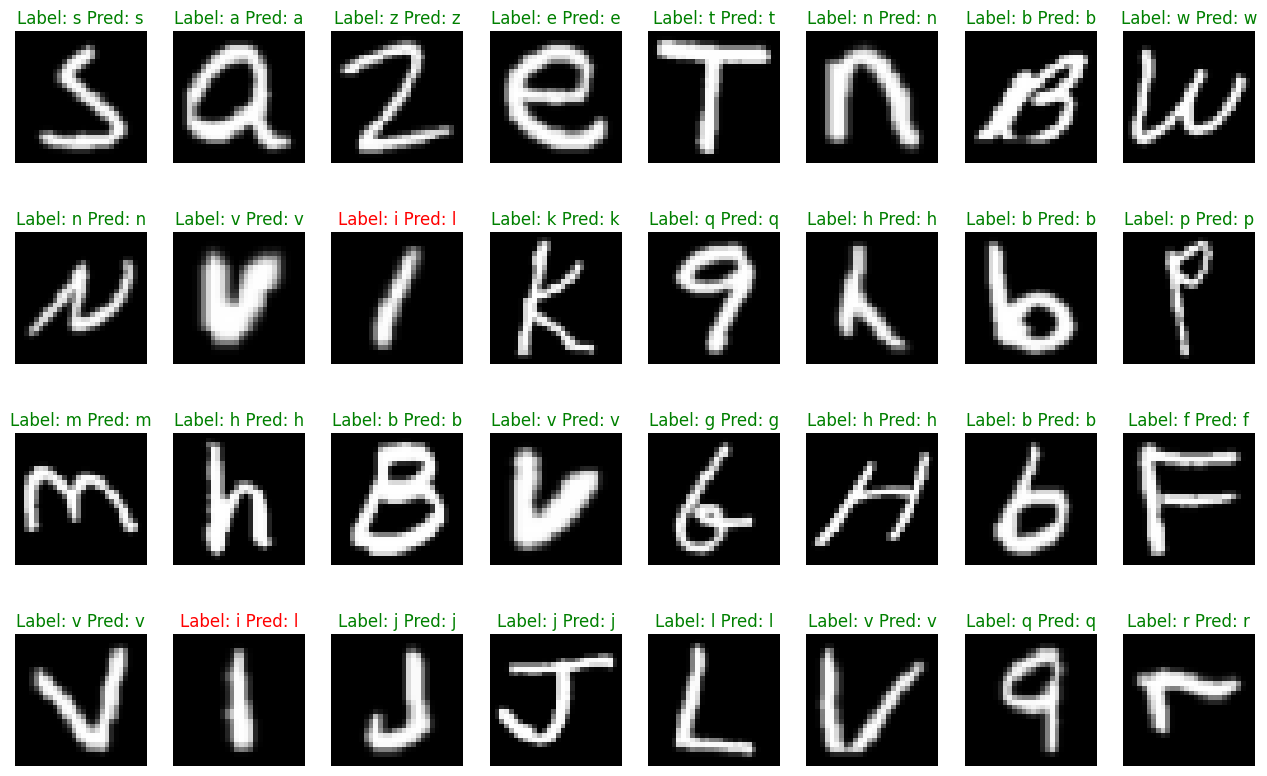

In [ ]:
# Show random Prediction
import numpy as np
fig = plt.figure(figsize=(16, 10))
rows, columns = 4, 8
for i, index in enumerate(np.random.randint(0, len(test_data), size=rows*columns)):
  plt.subplot(rows, columns, i+1)
  plt.imshow(test_data.data[index].data.T, cmap='gray')
  color = 'g' if test_data.targets[index]==pred_probs[index].argmax(dim=0) else 'r'
  plt.title(f'Label: {class_names[test_data.targets[index]]} Pred: {class_names[pred_probs[index].argmax(dim=0)]}', c=color)
  plt.axis(False)

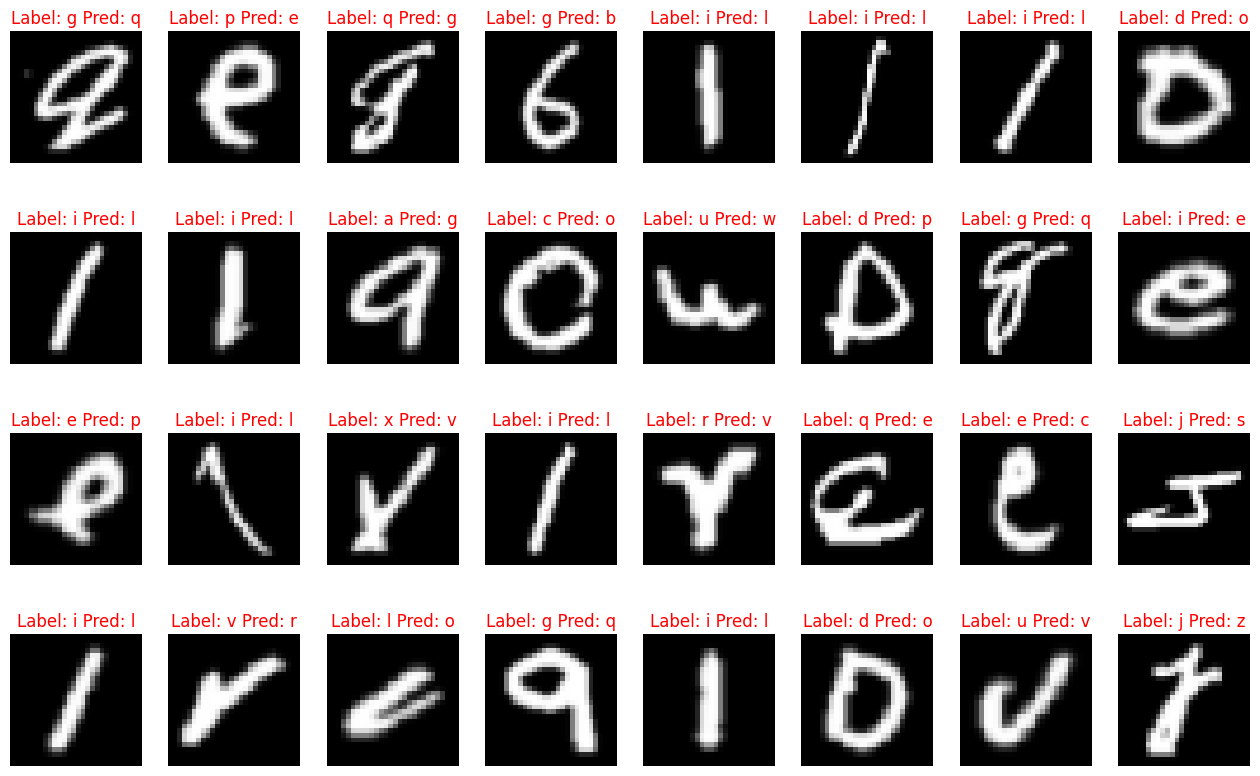

In [ ]:
# Show incorrect predictions
import random
wrong_prediction_index = torch.nonzero(pred_probs.argmax(dim=1)!=test_data.targets).squeeze()

fig = plt.figure(figsize=(16, 10))
rows, cols = 4, 8
for i, index in enumerate(random.sample(list(wrong_prediction_index), k=rows*cols)):
  plt.subplot(rows, columns, i+1)
  plt.imshow(test_data.data[index].data.T, cmap='gray')
  color = 'g' if test_data.targets[index]==pred_probs[index].argmax(dim=0) else 'r'
  plt.title(f'Label: {class_names[test_data.targets[index]]} Pred: {class_names[pred_probs[index].argmax(dim=0)]}', c=color)
  plt.axis(False)

### Confusion Matrix

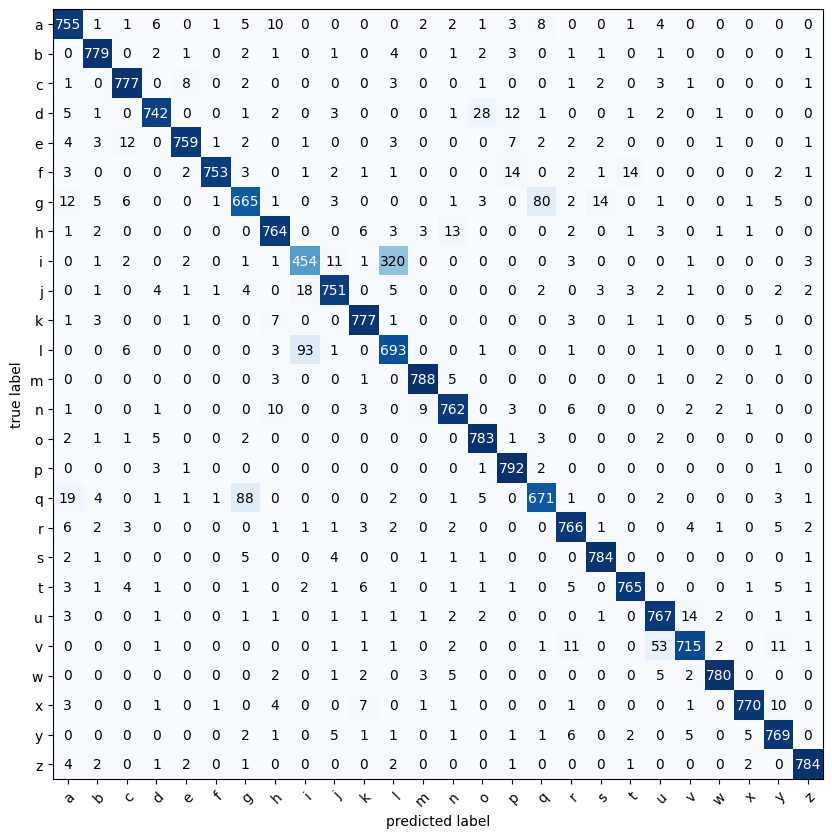

In [ ]:
# Plot confusion matrix
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_pred = pred_probs.argmax(dim=1).numpy()
y_target = test_data.targets.numpy()

cm = confusion_matrix(y_target=y_target,
                      y_predicted=y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                class_names=class_names[1:],
                                figsize=(10, 10))

### Saving the model

In [ ]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path('drive/MyDrive/ML/ZTM PyTorch/models')
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_EMINST.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: drive/MyDrive/ML/ZTM PyTorch/models/03_pytorch_computer_vision_model_EMINST.pth


In [ ]:
# Create a new instance model (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
INPUT_SHAPE = 1
HIDDEN_UNITS = 20
OUTPUT_SHAPE = len(class_names)

loaded_model = MNISTModel(input_shape=INPUT_SHAPE,
                            hidden_units=HIDDEN_UNITS,
                            output_shape=OUTPUT_SHAPE)

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model = loaded_model.to(device)

In [ ]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_result = eval_model(
    model=loaded_model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    acc_fn=acc_fn
)

loaded_model_result

{'model_name': 'MNISTModel',
 'model_loss': 0.20646841824054718,
 'model_acc': 0.9310095906257629}

In [ ]:
model_result

{'model_name': 'MNISTModel',
 'model_loss': 0.20646841824054718,
 'model_acc': 0.9310095906257629}

In [ ]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model_result["model_loss"]),
              torch.tensor(loaded_model_result["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)